### erddapy example for PMEL tools - Drifters and Alamo Floats (2018)

__pyversion__==3.6   
__author__==S.Bell

### connecting and basic information

In [31]:
from erddapy import ERDDAP
import pandas as pd
import numpy as np

server_url='http://downdraft.pmel.noaa.gov:8080/erddap'
e = ERDDAP(server=server_url)

Get only ARGOS Drifter datafiles

In [32]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='float'))

In [33]:
argos = df['Dataset ID'].values
print(argos)

['arctic_heat_alamo_profiles_9058' 'arctic_heat_alamo_profiles_9076'
 'arctic_heat_alamo_profiles_9085' 'arctic_heat_alamo_profiles_9115'
 'arctic_heat_alamo_profiles_9116' 'arctic_heat_alamo_profiles_9117'
 'arctic_heat_alamo_profiles_9119' 'arctic_heat_alamo_profiles_9150'
 'arctic_heat_alamo_profiles_9152' 'arctic_heat_alamo_profiles_9153'
 '2015_Argos_Drifters' '2016_Argos_Drifters' '2017_Argos_Drifters'
 '2018_Argos_Drifters' 'erdGtsppBest']


In [34]:
kw = {
    'standard_name': 'sea_water_temperature',
    'min_lon': -360,
    'max_lon': 540,
    'min_lat': 50.0,
    'max_lat': 90.0,
    'min_time': '2018-01-10T00:00:00Z',
    'max_time': '2019-01-10T00:00:00Z'
}

In [35]:
variables = [e.get_var_by_attr(dataset_id=float, long_name=lambda v: v is not None) for float in argos]

In [36]:
common_variables = set(variables[0]).intersection(*variables[1:])

#common_variables.update(['trajectory_id']) 
common_variables

{'latitude', 'longitude', 'time'}

In [37]:
constraints = {
    'longitude>=': kw['min_lon'],
    'longitude<=': kw['max_lon'],
    'latitude>=': kw['min_lat'],
    'latitude<=': kw['max_lat'],
    'time>=': kw['min_time'],
    'time<=': kw['max_time'],
}

download_url = e.get_download_url(
    dataset_id=argos[0],
    protocol='tabledap',
    response='csv',
    variables=common_variables,
    constraints=constraints
)

print(download_url)



http://downdraft.pmel.noaa.gov:8080/erddap/tabledap/arctic_heat_alamo_profiles_9058.csv?time,latitude,longitude&longitude>=-360&longitude<=540&latitude>=50.0&latitude<=90.0&time>=1515542400.0&time<=1547078400.0


In [38]:
from requests.exceptions import HTTPError

dfs = {}
for arfloat in argos:
    print(arfloat)
    try:
        e = ERDDAP(server=server_url,
            protocol='tabledap',
            response='csv'
        )
        e.constraints=constraints
        e.variables=common_variables
        e.dataset_id=arfloat
    except HTTPError:
        print('Failed to generate url {}'.format(alamo))
        continue
    try:
        dfs.update({arfloat: e.to_pandas(
                            index_col='time',
                            parse_dates=True,
                            skiprows=(1,)  # units information can be dropped.
                            )})
    except:
        pass

arctic_heat_alamo_profiles_9058
arctic_heat_alamo_profiles_9076
arctic_heat_alamo_profiles_9085
arctic_heat_alamo_profiles_9115
arctic_heat_alamo_profiles_9116
arctic_heat_alamo_profiles_9117
arctic_heat_alamo_profiles_9119
arctic_heat_alamo_profiles_9150
arctic_heat_alamo_profiles_9152
arctic_heat_alamo_profiles_9153
2015_Argos_Drifters
2016_Argos_Drifters
2017_Argos_Drifters
2018_Argos_Drifters
erdGtsppBest


In [39]:
for float, df in dfs.items():
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2586 entries, 2018-06-17 09:38:07 to 2018-07-30 21:05:58
Data columns (total 2 columns):
latitude     2586 non-null float64
longitude    2586 non-null float64
dtypes: float64(2)
memory usage: 60.6 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5351 entries, 2018-06-17 02:44:18 to 2018-07-30 21:06:02
Data columns (total 2 columns):
latitude     5351 non-null float64
longitude    5351 non-null float64
dtypes: float64(2)
memory usage: 125.4 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3372 entries, 2018-06-17 09:37:06 to 2018-07-30 21:07:29
Data columns (total 2 columns):
latitude     3372 non-null float64
longitude    3372 non-null float64
dtypes: float64(2)
memory usage: 79.0 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27064 entries, 2018-03-02 02:27:00 to 2018-07-30 23:21:00
Data columns (total 2 columns):
latitude     27064 non-null float64
longitude    27064 non-null float64
dtypes: fl

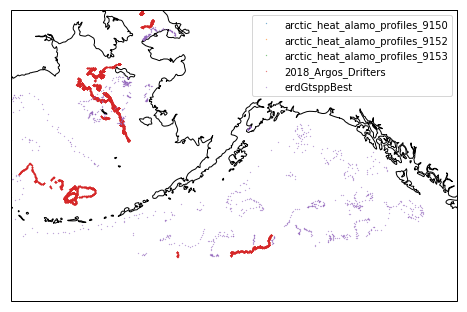

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(8, 8),
                           subplot_kw=dict(projection=projection))
    if projection == ccrs.PlateCarree():
        gl = ax.gridlines(draw_labels=True)
        gl.xlabels_top = gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

projection=ccrs.LambertConformal(central_longitude=-160.0)
transformation=ccrs.PlateCarree()

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='1.0')

dx = dy = 0.5
extent = -180, -130, kw['min_lat']+dy, kw['max_lat']+dy
extent = [-180, -130, 45, 66]
fig,ax = make_map(projection=projection)
for float, df in dfs.items():
    ax.plot(df['longitude'], df['latitude'], '.', markersize=0.5, label=float, transform=transformation)

leg = ax.legend()

ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)

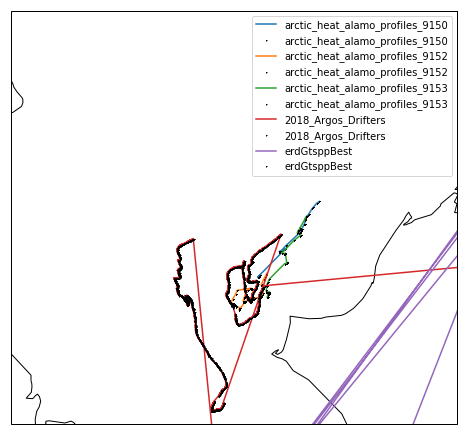

In [41]:

projection=ccrs.LambertConformal(central_longitude=-160.0)
transformation=ccrs.PlateCarree()

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='1.0')

dx = dy = 0.5
extent = [-176, -160, 67.5, 72.5]

fig,ax = make_map(projection=projection)
for alamo, df in dfs.items():
    ax.plot(df['longitude'], df['latitude'], label=alamo, transform=transformation)
    ax.plot(df['longitude'], df['latitude'], '+k', markersize=1, label=alamo, transform=transformation)

leg = ax.legend()

ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)